# NEURON STYLE TRANSFER

- In this project, we are able to apply the style of one image over the content of another image. 

In [2]:
# import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from tensorflow.keras import Model

In [3]:
# access the weights of VGG19
vgg= tf.keras.applications.VGG19(include_top=True,weights='imagenet')

574717952/574710816 [==============================] - 4s 0us/step


In [ ]:
# save the weights of VGG19 

%cd /content/drive/MyDrive/neuron_style_transfer
vgg.save_weights('vgg_weights.h5')

/content/drive/MyDrive/neuron_style_transfer


In [4]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

* GRAM MATRIX :

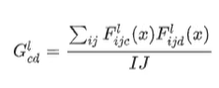

In [5]:
# Define the gram matrix

def gram_matrix(tensor_input):

  # in order to solve sigma function part we have a predefined library in tensorflow known as einsum
  ans=tf.linalg.einsum('bijc,bijd->bcd',tensor_input,tensor_input)
  g_mat=tf.expand_dims(ans,axis=0)
  input_shape=tf.shape(tensor_input)
  I=input_shape[1]
  J=input_shape[2]
  data=tf.cast(I*J,dtype=tf.float32)
  
  return g_mat/data 

### MODEL LOADING

In [6]:
# load the model

def load_vgg():

  vgg=tf.keras.applications.VGG19(include_top=True,weights=None)
  vgg.load_weights('/content/drive/MyDrive/neuron_style_transfer/vgg_weights.h5')
  vgg.trainable=False

  content_layers=['block4_conv2']
  style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

  # access output of content and style layers

  content_output=vgg.get_layer(content_layers[0]).output
  style_outputs=[]

  for style_layer in style_layers:

    style_outputs.append(vgg.get_layer(style_layer).output)

  gram_style_output=[]

  for style_output in style_outputs:

    gram_style_output.append(gram_matrix(style_output))

  # creating the required model
  model=Model([vgg.input],[content_output,gram_style_output])
  
  return model

In [7]:
# image preprocessing

def img_preprocessing(img_path):
  
  img=cv2.imread(img_path)
  img=cv2.resize(img,(224,224))
  img=tf.image.convert_image_dtype(img,tf.float32)
  return img

In [8]:
# define the optimizer

opt=tf.optimizers.Adam(learning_rate=0.01,beta_1=0.99,epsilon=1e-1)

Content Loss :

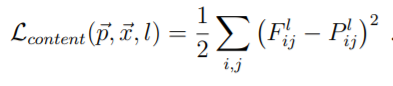

Style Loss :

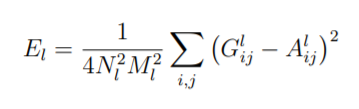

Total Loss :

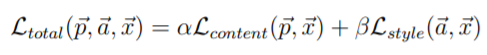


### LOSS FUNCTION

In [9]:
# define a loss function

def total_loss(style_output,content_output,style_target,content_target):

  style_weight= 1e-2
  content_weight= 1e-1
  content_loss=tf.reduce_mean((content_output-content_target)**2)
  style_loss=[]

  for x,y in zip(style_output,style_target):

    style_loss.append(tf.reduce_mean((x-y)**2))

  style_loss=tf.add_n(style_loss)
  total_loss=style_weight*style_loss + content_weight*content_loss
  
  return total_loss

### TRAIN A MODEL

In [10]:
# training the model
 
def train_step(image,vgg_model,content_target,style_target,epoch,loss_arr):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = total_loss(output[1], output[0], style_target, content_target)
  gradient = tape.gradient(loss, image)
  opt.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  loss_arr.append(loss)

### GET RESULTANT IMAGE

In [11]:
def get_hybrid_img(content_path,style_path,epoch,loss_arr):

  vgg_model=load_vgg()
  content_img=img_preprocessing(content_path)
  style_img=img_preprocessing(style_path)

  # 0th index of vgg_model gives content image and 1st index gives style image
  content_target=vgg_model(np.array([content_img*255]))[0]
  style_target=vgg_model(np.array([style_img*255]))[1]

  image = tf.Variable([content_img])

  for i in range(epoch):
    train_step(image,vgg_model,content_target,style_target,epoch,loss_arr)

  hybrid_img = image*255
  hybrid_img = np.array(hybrid_img, dtype=np.uint8)

  if np.ndim(hybrid_img)>3:
    assert hybrid_img.shape[0] == 1
    hybrid_img = hybrid_img[0]
  hybrid_img =  PIL.Image.fromarray(hybrid_img)

  return (hybrid_img,content_img,style_img)

### IMAGE VISUALIZATION

In [12]:
def visulizing_img(content_img,style_img,hybrid_img):

  fig = plt.figure(figsize=(12,12))

  ax = fig.add_subplot(131)
  ax2 = fig.add_subplot(132)
  ax3= fig.add_subplot(133)

  ax.title.set_text('Content Image')
  ax2.title.set_text('Style Image')
  ax3.title.set_text('Hybrid Image')

  ax.axis('off')
  ax.imshow(cv2.cvtColor(np.array(content_img), cv2.COLOR_BGR2RGB))
  
  ax2.axis('off')
  ax2.imshow(cv2.cvtColor(np.array(style_img), cv2.COLOR_BGR2RGB))
  
  ax3.axis('off')
  ax3.imshow(cv2.cvtColor(np.array(hybrid_img), cv2.COLOR_BGR2RGB))

In [13]:
content_path = '/content/drive/MyDrive/neuron_style_transfer/images/content.jpg'
style_path = '/content/drive/MyDrive/neuron_style_transfer/images/style.jpg'

loss_arr=[]

hybrid_img,content_img,style_img = get_hybrid_img(content_path,style_path,250,loss_arr)

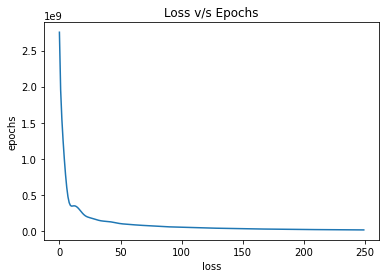

In [14]:
# analyse the performance of a model over epochs

plt.plot(loss_arr,)
plt.xlabel('loss')
plt.ylabel('epochs')
plt.title('Loss v/s Epochs')
plt.show()

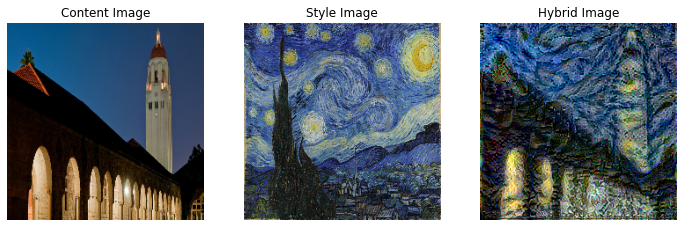

In [15]:
# visualize the image

visulizing_img(content_img,style_img,hybrid_img)

### VISUALIZE OUTPUTS OVER MORE STYLE IMAGES

In [16]:
content_path = '/content/drive/MyDrive/neuron_style_transfer/images/content.jpg'
style_path = '/content/drive/MyDrive/neuron_style_transfer/images/style1.jpg'

loss_arr=[]

hybrid_img,content_img,style_img = get_hybrid_img(content_path,style_path,250,loss_arr)

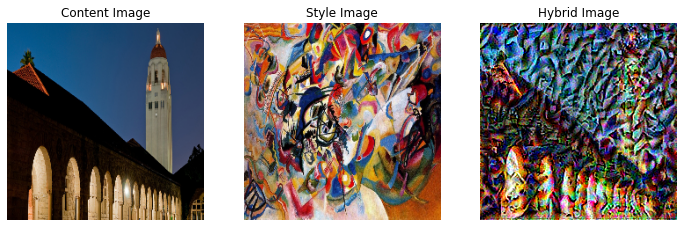

In [17]:
visulizing_img(content_img,style_img,hybrid_img)

In [18]:
content_path = '/content/drive/MyDrive/neuron_style_transfer/images/content.jpg'
style_path = '/content/drive/MyDrive/neuron_style_transfer/images/style2.jpg'

loss_arr=[]

hybrid_img,content_img,style_img = get_hybrid_img(content_path,style_path,250,loss_arr)

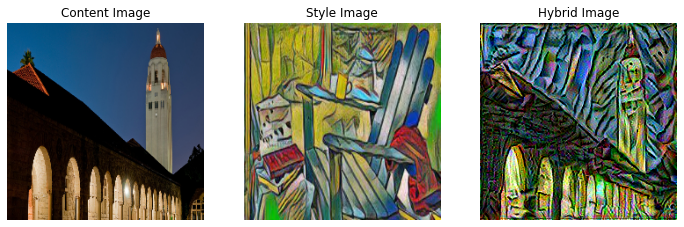

In [19]:
visulizing_img(content_img,style_img,hybrid_img)